In [1]:
import sys
import os
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [2]:
host = 'localhost'
user = 'postgres'
password = 'abcd1234'
database = 'tabd'

os.makedirs('plots', exist_ok=True)

In [3]:
def run_query(query, host=host, user=user, password=password, database=database):
    conn = None
    cur = None
    try:
        conn = psycopg2.connect(
            host=host,
            database=database,
            user=user,
            password=password
        )

        cur = conn.cursor()
        cur.execute(query)
        
        res = cur.fetchall()
        cols = [desc[0] for desc in cur.description]

        return res, cols

    except Exception as e:
        sys.stderr.write(e)
    finally:
        if cur is not None:
            cur.close()
        if conn is not None:
            conn.close()

## Number of athletes by age

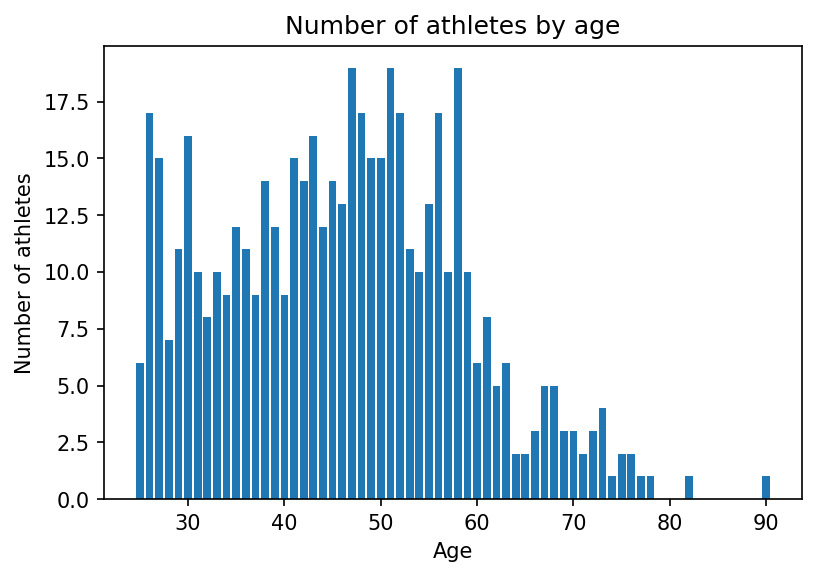

In [4]:
query = '''
SELECT
    COUNT(*),
    EXTRACT(YEAR FROM age(birthdate)) AS age
FROM annp_final.athlete
GROUP BY age
ORDER BY age ASC;
'''

res, _ = run_query(query)

plt.subplots(dpi=150)

xx = list(map(lambda x: int(x[1]), res))
yy = list(map(lambda x: x[0], res))

plt.title('Number of athletes by age')
plt.xlabel('Age')
plt.ylabel('Number of athletes')
plt.bar(xx, yy)

plt.savefig('plots/athletesbyage.png')

## Number of athletes by age and gender

**NOTE:** This plot is in the file `athletesbygenderandage.py` because it is too wide to fit in the notebook. To generate the plot run 

> python3 athletesbygenderandage.py

or 

> ./athletesbygenderandage.py

## Number of athletes by nation

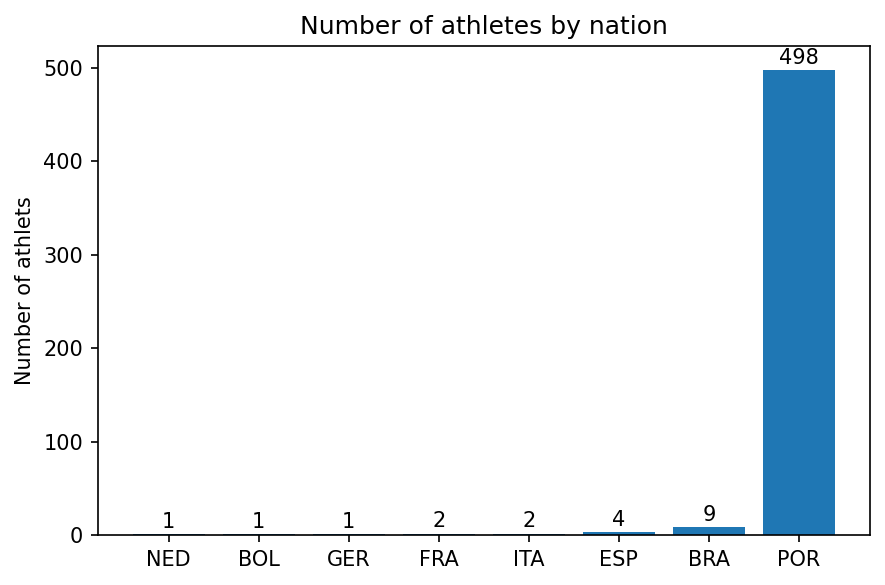

In [5]:
query = '''
SELECT
    nation,
    COUNT(*) AS nationCount
FROM annp_final.athlete
GROUP BY nation
ORDER BY nationCount ASC;
'''

res, _ = run_query(query)

xx = list(map(lambda x: x[0], res))
yy = list(map(lambda x: x[1], res))

x = np.arange(len(xx))

fig, ax = plt.subplots(dpi=150)

rects = ax.bar(x, yy)

ax.set_ylabel('Number of athlets')
ax.set_title('Number of athletes by nation')
ax.set_xticks(x, xx)

ax.bar_label(rects, padding=1)

plt.tight_layout()

plt.savefig('plots/athletesbynation.png')

## Number of atheletes by nation and gender

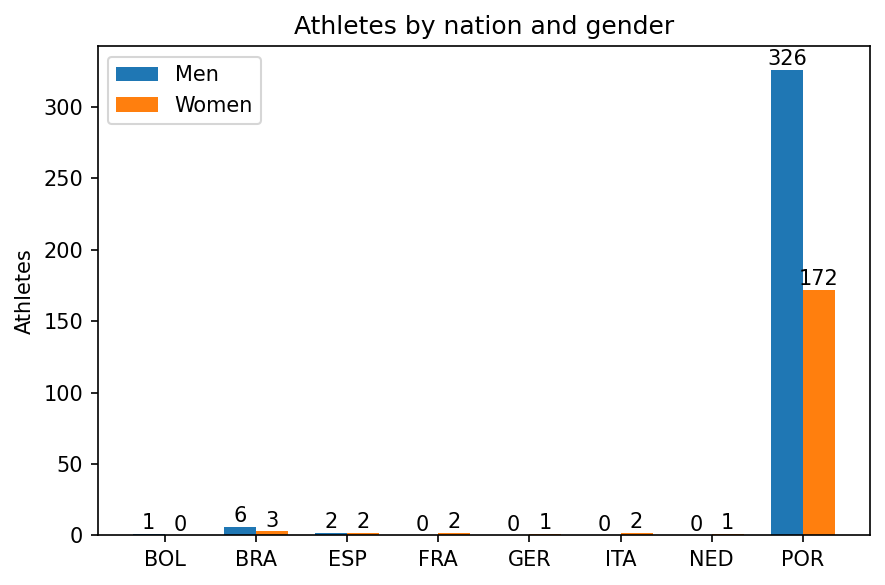

In [6]:
query = '''
    SELECT 
        nation,
        gender,
        count(*)
    FROM annp_final.athlete
    GROUP BY CUBE (nation, gender)
    ORDER BY nation, gender NULLS LAST;
'''

res, cols = run_query(query)

def get_info_for_bars(res):

    countries = []
    gender = []
    for el in res:
        if el[0] not in countries and el[0] is not None:
            countries.append(el[0])
        elif el[1] not in gender and el[1] is not None:
            gender.append(el[1])
        else:
                pass

    nat_gen = [(c, g) for c in countries for g in gender]

    resn = []
    for el in res:
        if el[0] is None or el[1] is None:
            pass
        else:
            resn.append((el[0], el[1]))
    
    diff = list(set(nat_gen) - set(resn))
    
    for i in range(len(diff)):
        diff[i] = diff[i] + (0,)
    
    res_f = []
    for el in res:
        if el[0] is None or el[1] is None:
            pass
        else:
            res_f.append((el[0], el[1], el[2]))
    
    res_f = (res_f + diff)
    res_f.sort()
    count_female = []
    count_male = []

    for row in res_f:
        if row[1] == "F":
            count_female.append(row[2])
        elif row[1] == "M":
            count_male.append(row[2])
        else:
            pass
        
    return countries, count_male, count_female

countries, count_male, count_female = get_info_for_bars(res)

count_male
count_female
countries

x = np.arange(len(countries))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(dpi=150)
rects1 = ax.bar(x - width/2, count_male, width, label='Men')
rects2 = ax.bar(x + width/2, count_female, width, label='Women')

ax.set_ylabel('Athletes')
ax.set_title('Athletes by nation and gender')
ax.set_xticks(x, countries)
ax.legend()

ax.bar_label(rects1, padding=.3)
ax.bar_label(rects2, padding=.3)

fig.tight_layout()

plt.savefig('plots/athletesbynationgender.png')


## Number of athletes by gender

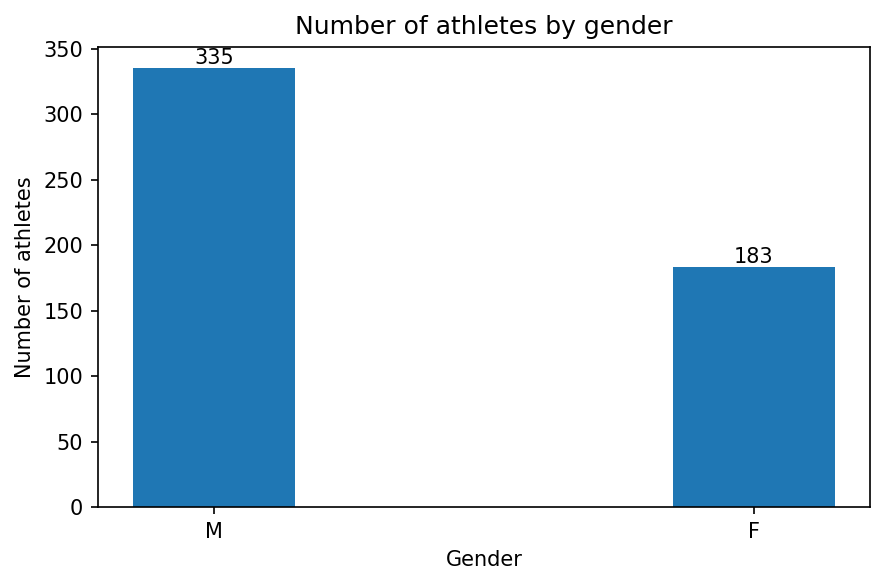

In [7]:
query = '''
SELECT
    gender,
    COUNT(*)
FROM annp_final.athlete
GROUP BY gender;
'''

res, _ = run_query(query)

fig, ax = plt.subplots(dpi=150)

xx = list(map(lambda x: x[0], res))
yy = list(map(lambda x: x[1], res))

ax.set_title('Number of athletes by gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Number of athletes')

rects = plt.bar(xx, yy, width=.3)

ax.bar_label(rects, padding=0)

plt.tight_layout()

plt.savefig('plots/athletesbygender.png')

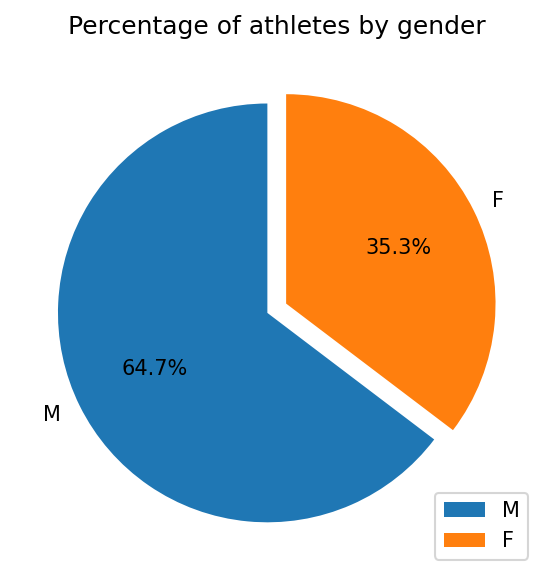

In [8]:
plt.subplots(dpi=150)

plt.title('Percentage of athletes by gender')
plt.pie(yy, labels=xx, explode=(0.05, 0.05), autopct='%1.1f%%', startangle=90)

plt.legend()
plt.tight_layout()
plt.legend()

plt.savefig('plots/athletesbygender-pie.png')

## Clubs by Nation

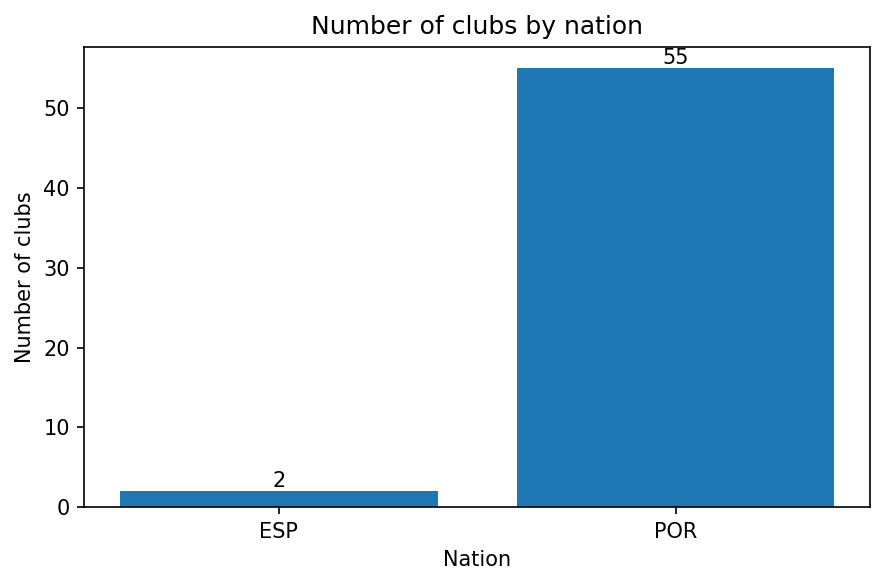

In [9]:
query = '''
SELECT nation, COUNT(*) AS nationCount
FROM annp_final.club
GROUP BY nation
ORDER BY nationCount ASC;
'''

res, _ = run_query(query)

fig, ax = plt.subplots(dpi=150)

xx = list(map(lambda x: x[0], res))
yy = list(map(lambda x: x[1], res))

ax.set_title('Number of clubs by nation')
ax.set_xlabel('Nation')
ax.set_ylabel('Number of clubs')

rects = ax.bar(xx, yy)

ax.bar_label(rects, padding=0)

plt.tight_layout()

plt.savefig('plots/clubsbynation.png')

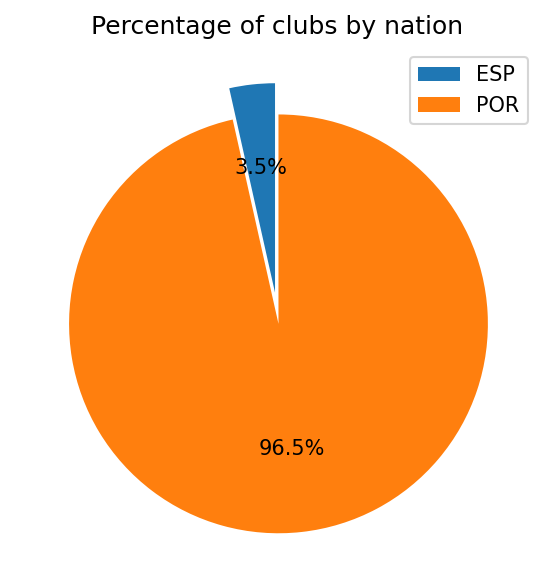

In [10]:
plt.subplots(dpi=150)

plt.title('Percentage of clubs by nation')
plt.pie(yy, explode=(0.075, 0.075), autopct='%1.1f%%', startangle=90)

plt.legend(labels=xx)
plt.tight_layout()

plt.savefig('plots/clubsbynation-pie.png')

## Clubs by Region (PT)

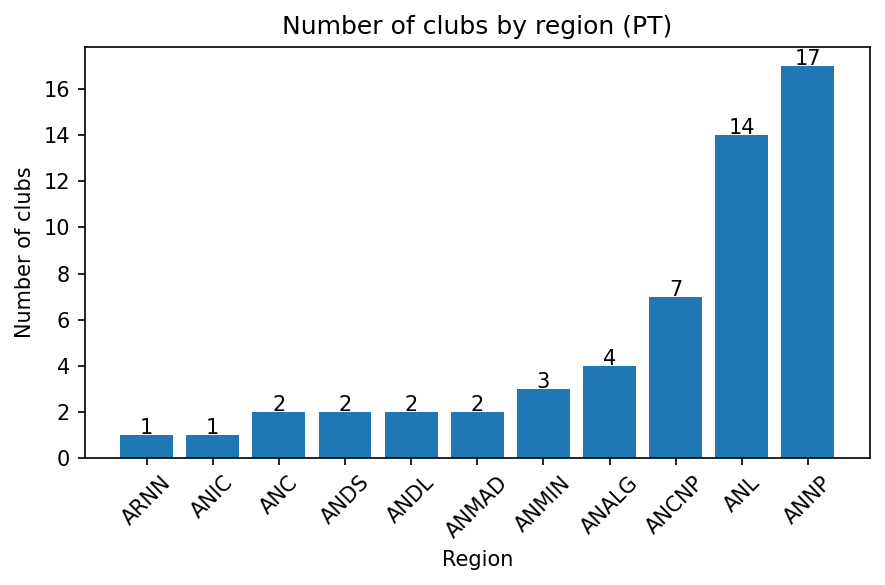

In [11]:
query = '''
SELECT region, COUNT(*) AS regionCount
FROM annp_final.club
WHERE region SIMILAR TO '[A-Z]+'
GROUP BY region
ORDER BY regionCount ASC;
'''
autopct='%1.1f%%'
res, _ = run_query(query)

fig, ax = plt.subplots(dpi=150)

xx = list(map(lambda x: x[0], res))
yy = list(map(lambda x: x[1], res))

ax.set_title('Number of clubs by region (PT)')
ax.set_xlabel('Region')
ax.set_ylabel('Number of clubs')

rects = ax.bar(xx, yy)
plt.xticks(rotation=45)

ax.bar_label(rects, padding=-1.5)

plt.tight_layout()

plt.savefig('plots/clubsbyregion-pt.png')

## Clubs by Region (ES)

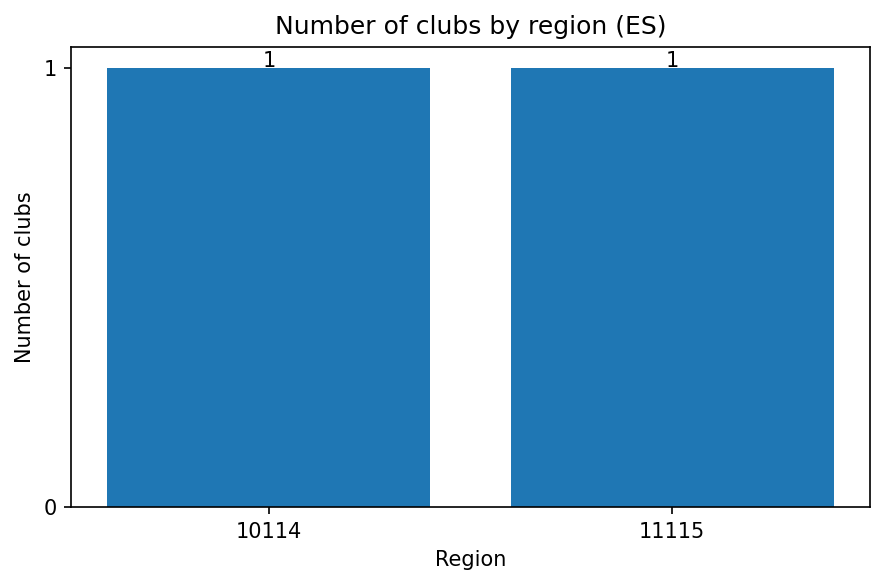

In [12]:
query = '''
SELECT region, COUNT(*) AS regionCount
FROM annp_final.club
WHERE region SIMILAR TO '[0-9]+'
GROUP BY region
ORDER BY regionCount ASC;
'''

res, _ = run_query(query)

fig, ax = plt.subplots(dpi=150)

xx = list(map(lambda x: x[0], res))
yy = list(map(lambda x: x[1], res))

ax.set_title('Number of clubs by region (ES)')
ax.set_xlabel('Region')
ax.set_ylabel('Number of clubs')
ax.set_yticks([0, 1])
rects = ax.bar(xx, yy)

ax.bar_label(rects, padding=-1)

plt.tight_layout()

plt.savefig('plots/clubsbyregion-es.png')

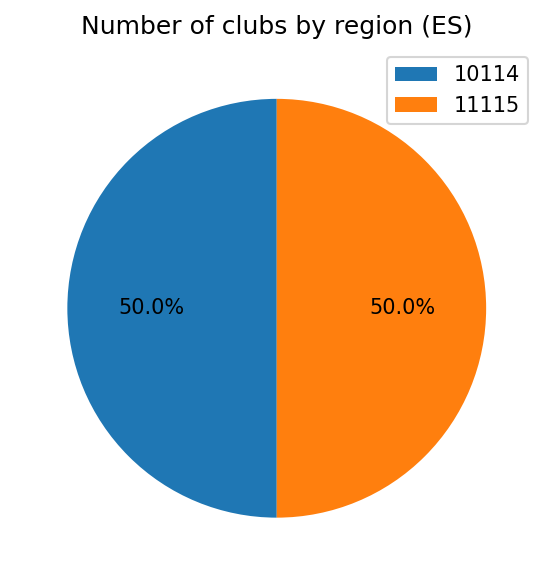

In [13]:
plt.subplots(dpi=150)

plt.title('Number of clubs by region (ES)')
plt.pie(yy, autopct='%1.1f%%', startangle=90)

plt.legend(labels=xx)
plt.tight_layout()

plt.savefig('plots/clubsbyregion-es-pie.png')

## Statistics by Tournament and Club

In [14]:
query = '''
SELECT 
    CASE GROUPING(cd.meetid)
        WHEN 1 THEN 'all_meets'
        ELSE cd.meetid
    END AS "Tournament",
    CASE GROUPING(c.code)
        WHEN 1 THEN 'all_clubs'
        ELSE c.code
    END AS "Team",
    ROUND(AVG(average_age), 0) AS "Average Age",
    ROUND(AVG(average_swimtime), 2) AS "Average Swimtime",
    ROUND(SUM(total_points)) AS "Total Points",
    ROUND(SUM(number_of_players)) AS "Total Players"
FROM (
    SELECT CAST(meetid AS VARCHAR(255)),
           clubid,
           average_age,
           total_points,
           average_swimtime,
           number_of_players
        FROM annp_final.club_defacto) cd
JOIN annp_final.club c ON c.clubid = cd.clubid
GROUP BY CUBE (cd.meetid, c.code);
'''

res, cols = run_query(query)

results = {}
for i in range(len(cols)):
    col = cols[i]
    results[col] = list(map(lambda x: x[i], res))
    
df = pd.DataFrame(results)

df_p = df.pivot_table(
    values=['Average Age', 'Average Swimtime', 'Total Points', 'Total Players'],
    index='Team',
    columns='Tournament',
    aggfunc=np.mean,
    fill_value=0
)

df_p.drop(index='all_clubs', inplace=True)

cols = list(df_p.columns.levels[0])
idx = df_p.index
x = np.arange(len(np.array(idx)))
clubs = np.array(df_p.index)


width = 0.28  #the width of the bars

fig, ax = plt.subplots(len(cols), figsize=(15,20), dpi=150)
ax.ravel()

for i in range(len(cols)):
    col = cols[i]

    col_1 = df_p[cols[i]].reset_index().iloc[:, 1].values
    col_2 = df_p[cols[i]].reset_index().iloc[:, 2].values
    col_3 = df_p[cols[i]].reset_index().iloc[:, 3].values

    ax[i].bar(x + width , col_1, width, label='Masters Verão')
    ax[i].bar(x, col_2, width, label='Pescada')
    ax[i].bar(x - width, col_3, width, label='All')

    ax[i].set_xticks(x, clubs, rotation=90)
    
    ax[i].set_xlabel('Teams')
    ax[i].set_ylabel("{colname}".format(colname=col))
    ax[i].set_title("{colname} by club".format(colname=col))
    ax[i].legend()
plt.tight_layout()
plt.savefig('plots/club_fact1.pdf')

TypeError: write() argument must be str, not <class 'psycopg2.errors.UndefinedTable'>

## Statistics by Club and Swimstyle

In [ ]:
query='''
SELECT 
    CASE GROUPING(c.code)
        WHEN 1 THEN 'all_clubs'
        ELSE c.code
    END AS "Team",
    CASE GROUPING(cd.swimstyleid)
        WHEN 1 THEN 'all_styles'
        ELSE cd.swimstyleid
    END AS "SwimStyle",
    ROUND(AVG(average_swimtime), 2) AS "Average Swimtime",
    ROUND(SUM(total_points)) AS "Total Points",
    ROUND(SUM(number_of_players)) AS "Total Players"
FROM annp_final.club_defacto cd
JOIN annp_final.club c on c.clubid = cd.clubid
GROUP BY CUBE (c.code, cd.swimstyleid)
ORDER BY "Total Points" DESC
'''

res, cols = run_query(query)

results = {}
for i in range(len(cols)):
    col = cols[i]
    results[col] = list(map(lambda x: x[i], res))
    
df = pd.DataFrame(results)

df = df.sort_values(["SwimStyle", "Total Points"], ascending=False).groupby(["SwimStyle"]).head(6)

df_p = df.pivot_table(
    values=['Average Swimtime', 'Total Points', 'Total Players'],
    index='Team',
    columns='SwimStyle',
    aggfunc=np.mean,
    fill_value="drop_this"
)

# shuffle swimstyles and only select 10 of them
swimstyles = list(df_p.columns.levels[1])
stats = list(df_p.columns.levels[0])

random.shuffle(swimstyles)
swimstyles = swimstyles[:10]
df_p.drop(index="all_clubs", inplace=True)

fig, ax = plt.subplots(len(stats), len(swimstyles), figsize=(60, 15), dpi=150)

ax = ax.ravel()

i = 0
for stat in stats:

    for swimstyle in swimstyles:

        ds = df_p[stat][swimstyle][df_p[stat][swimstyle] != "drop_this"]

        ax[i].bar(x=ds.index, height=ds)
        
        if i % len(swimstyles) == 0:
            ax[i].set_ylabel(stat, size=25)
        if i < len(swimstyles):
            ax[i].set_title(swimstyle, size=25)
        
        ax[i].tick_params(axis='both', labelsize=20)
        ax[i].tick_params(axis='x', labelrotation=45)
        
        i+=1
        


plt.tight_layout()
plt.savefig("plots/stats_clubs_swim.pdf", dpi=200)

## Athlete Statistics

In [ ]:
query = '''
SELECT
    CASE GROUPING(a.firstname)
        WHEN 1 THEN 'all_players'
        ELSE a.firstname
    END AS "Athletes",
    CASE GROUPING(af.meetid)
        WHEN 1 THEN 'all_meets'
        ELSE af.meetid
    END AS "Tournament",
    ROUND(AVG(average_points), 2) AS "Average Points",
    ROUND(AVG(average_distance), 2) AS "Average Distance",
    ROUND(AVG(average_swimtime), 2) AS "Average Swimtime"
FROM (
    SELECT
        athleteid,
        CAST(meetid as VARCHAR(255)),
        average_points,
        average_distance,
        average_swimtime
    FROM annp_final.athlete_defacto) af
JOIN annp_final.athlete a ON a.athleteid = af.athleteid
GROUP BY CUBE (a.firstname, af.meetid)
ORDER BY "Average Points" DESC
LIMIT 50;
'''

res, cols = run_query(query)

results = {}
for i in range(len(cols)):
    col = cols[i]
    results[col] = list(map(lambda x: x[i], res))
    
df = pd.DataFrame(results)

df_p = df.pivot_table(
    values=['Average Points', 'Average Distance', 'Average Swimtime'],
    index='Athletes',
    columns='Tournament',
    aggfunc=np.mean,
    fill_value=0
)

cols = list(df_p.columns.levels[0])
idx = df_p.index
x = np.arange(len(np.array(idx)))
clubs = np.array(df_p.index)


width = 0.28  #the width of the bars

fig, ax = plt.subplots(len(cols), figsize=(15,20), dpi=150)
ax.ravel()

for i in range(len(cols)):
    col = cols[i]

    col_1 = df_p[cols[i]].reset_index().iloc[:, 1].values
    col_2 = df_p[cols[i]].reset_index().iloc[:, 2].values
    col_3 = df_p[cols[i]].reset_index().iloc[:, 3].values

    ax[i].bar(x + width , col_1, width, label='Masters Verão')
    ax[i].bar(x, col_2, width, label='Pescada')
    ax[i].bar(x - width, col_3, width, label='All')

    ax[i].set_xticks(x, clubs, rotation=90)
    
    ax[i].set_xlabel('Athlete')
    ax[i].set_ylabel("{colname}".format(colname=col))
    ax[i].set_title("{colname} by athlete".format(colname=col))
    ax[i].legend()
plt.tight_layout()
plt.savefig('plots/athletefact.pdf')